In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

load_dotenv()  # loads from .env in the current directory

# Database connection info - load from environment variables
MYSQL_USER = os.getenv('MYSQL_USER')
MYSQL_PASSWORD = os.getenv('MYSQL_PASSWORD')
MYSQL_HOST = os.getenv('MYSQL_HOST')
MYSQL_PORT = os.getenv('MYSQL_PORT')
MYSQL_DATABASE = os.getenv('MYSQL_DATABASE')
TABLE_NAME = '311_complaints_2'

# Create engine
engine = create_engine(f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DATABASE}')


In [2]:
query = text(f"""
SELECT COUNT(*) AS total_rows FROM {TABLE_NAME};
""")
with engine.connect() as conn:
    df_total_rows = pd.read_sql(query, conn)

df_total_rows


,total_rows
0,963996


In [7]:
query = text(f"""
SELECT COUNT(DISTINCT unique_key) AS unique_keys FROM {TABLE_NAME};
""")
with engine.connect() as conn:
    df_unique_keys = pd.read_sql(query, conn)

df_unique_keys


,unique_keys
0,963996


In [8]:
query = text(f"""
SELECT
    SUM(CASE WHEN incident_zip IS NULL THEN 1 ELSE 0 END) AS null_incident_zip,
    SUM(CASE WHEN vehicle_type IS NULL THEN 1 ELSE 0 END) AS null_vehicle_type,
    SUM(CASE WHEN landmark IS NULL THEN 1 ELSE 0 END) AS null_landmark
FROM {TABLE_NAME};
""")
with engine.connect() as conn:
    df_nulls = pd.read_sql(query, conn)

df_nulls


,null_incident_zip,null_vehicle_type,null_landmark
0,11117.0,916993.0,963996.0


In [9]:
query = text(f"""
SELECT
    MIN(latitude) AS min_lat,
    MAX(latitude) AS max_lat,
    AVG(latitude) AS avg_lat
FROM {TABLE_NAME}
WHERE latitude IS NOT NULL;
""")
with engine.connect() as conn:
    df_lat_stats = pd.read_sql(query, conn)

df_lat_stats


,min_lat,max_lat,avg_lat
0,40.4988,40.9129,40.736299


In [10]:
query = text(f"""
SELECT
    MIN(created_date) AS start_date,
    MAX(created_date) AS end_date
FROM {TABLE_NAME};
""")
with engine.connect() as conn:
    df_date_range = pd.read_sql(query, conn)

df_date_range


,start_date,end_date
0,2024-01-01,2024-04-20 17:32:07


In [11]:
query = text(f"""
SELECT DATE_FORMAT(created_date, '%Y-%m') AS month, COUNT(*) AS total
FROM {TABLE_NAME}
GROUP BY month
ORDER BY month;
""")
with engine.connect() as conn:
    df_monthly = pd.read_sql(query, conn)

df_monthly


,month,total
0,2024-01,287199
1,2024-02,240453
2,2024-03,259699
3,2024-04,176645


In [12]:
query = text(f"""
SELECT complaint_type, COUNT(*) AS count
FROM {TABLE_NAME}
GROUP BY complaint_type
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_top_complaints = pd.read_sql(query, conn)

df_top_complaints


,complaint_type,count
0,Illegal Parking,149900
1,HEAT/HOT WATER,117284
2,Noise - Residential,83157
3,Blocked Driveway,51718
4,UNSANITARY CONDITION,33908
5,Street Condition,24776
6,PLUMBING,21657
7,Abandoned Vehicle,21622
8,Noise - Street/Sidewalk,21302
9,PAINT/PLASTER,20836


In [13]:
query = text(f"""
SELECT borough, COUNT(*) AS count
FROM {TABLE_NAME}
GROUP BY borough
ORDER BY count DESC;
""")
with engine.connect() as conn:
    df_borough = pd.read_sql(query, conn)

df_borough


,borough,count
0,BROOKLYN,298609
1,QUEENS,231667
2,MANHATTAN,203172
3,BRONX,196139
4,STATEN ISLAND,33674
5,Unspecified,735


In [14]:
query = text(f"""
SELECT incident_zip, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE incident_zip IS NOT NULL
GROUP BY incident_zip
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_zip = pd.read_sql(query, conn)

df_zip


,incident_zip,count
0,11226,15789
1,10467,15044
2,10457,14190
3,10468,14092
4,11201,14030
5,10456,13302
6,10458,12713
7,10452,12619
8,11207,12157
9,11385,11806


In [15]:
query = text(f"""
SELECT
    MIN(latitude) AS min_lat,
    MAX(latitude) AS max_lat,
    MIN(longitude) AS min_lon,
    MAX(longitude) AS max_lon
FROM {TABLE_NAME}
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")
with engine.connect() as conn:
    df_bounds = pd.read_sql(query, conn)

df_bounds


,min_lat,max_lat,min_lon,max_lon
0,40.4988,40.9129,-74.2544,-73.7007


In [16]:
query = text(f"""
SELECT
    complaint_type,
    AVG(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS avg_hours_to_resolve
FROM {TABLE_NAME}
WHERE created_date IS NOT NULL AND closed_date IS NOT NULL
GROUP BY complaint_type
ORDER BY avg_hours_to_resolve DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_resolution = pd.read_sql(query, conn)

df_resolution


,complaint_type,avg_hours_to_resolve
0,New Tree Request,9067.8449
1,Day Care,7646.8141
2,Tattooing,7530.8033
3,Mobile Food Vendor,7497.2428
4,Poison Ivy,7476.0000
5,Window Guard,7248.7500
6,Lot Condition,7012.4128
7,Calorie Labeling,6971.0000
8,Smoking or Vaping,4223.3020
9,Adopt-A-Basket,3559.9167


In [17]:
query = text(f"""
SELECT agency, agency_name, COUNT(*) AS complaint_count
FROM {TABLE_NAME}
GROUP BY agency, agency_name
ORDER BY complaint_count DESC;
""")
with engine.connect() as conn:
    df_agency_complaints = pd.read_sql(query, conn)

df_agency_complaints


,agency,agency_name,complaint_count
0,NYPD,New York City Police Department,388894
1,HPD,Department of Housing Preservation and Develop...,263081
2,DSNY,Department of Sanitation,80201
3,DOT,Department of Transportation,67464
4,DEP,Department of Environmental Protection,47540
5,DOB,Department of Buildings,30545
6,DPR,Department of Parks and Recreation,27327
7,DOHMH,Department of Health and Mental Hygiene,23882
8,TLC,Taxi and Limousine Commission,10829
9,DHS,Department of Homeless Services,9666


In [18]:
query = text(f"""
SELECT complaint_type, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY complaint_type
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_nypd_complaints = pd.read_sql(query, conn)

df_nypd_complaints


,complaint_type,count
0,Illegal Parking,149900
1,Noise - Residential,83157
2,Blocked Driveway,51718
3,Abandoned Vehicle,21622
4,Noise - Street/Sidewalk,21302
5,Noise - Commercial,18666
6,Noise - Vehicle,12426
7,Non-Emergency Police Matter,6455
8,Encampment,6161
9,Drug Activity,4829


In [19]:
query = text(f"""
SELECT complaint_type, descriptor, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY complaint_type, descriptor
ORDER BY count DESC
LIMIT 15;
""")
with engine.connect() as conn:
    df_nypd_descriptors = pd.read_sql(query, conn)

df_nypd_descriptors


,complaint_type,descriptor,count
0,Illegal Parking,Blocked Hydrant,43065
1,Noise - Residential,Loud Music/Party,39309
2,Blocked Driveway,No Access,37071
3,Noise - Residential,Banging/Pounding,34995
4,Illegal Parking,Posted Parking Sign Violation,34306
5,Abandoned Vehicle,With License Plate,21622
6,Illegal Parking,Blocked Sidewalk,16879
7,Noise - Commercial,Loud Music/Party,15227
8,Blocked Driveway,Partial Access,14647
9,Noise - Street/Sidewalk,Loud Music/Party,14258


In [20]:
query = text(f"""
SELECT DATE_FORMAT(created_date, '%Y-%m') AS month, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY month
ORDER BY month;
""")
with engine.connect() as conn:
    df_nypd_monthly = pd.read_sql(query, conn)

df_nypd_monthly


,month,count
0,2024-01,103952
1,2024-02,98779
2,2024-03,111240
3,2024-04,74923


In [21]:
query = text(f"""
SELECT borough, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY borough
ORDER BY count DESC;
""")
with engine.connect() as conn:
    df_nypd_boroughs = pd.read_sql(query, conn)

df_nypd_boroughs


,borough,count
0,BROOKLYN,129194
1,QUEENS,111728
2,MANHATTAN,72495
3,BRONX,64711
4,STATEN ISLAND,10747
5,Unspecified,19


In [22]:
query = text(f"""
SELECT incident_zip, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND incident_zip IS NOT NULL
GROUP BY incident_zip
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_nypd_zips = pd.read_sql(query, conn)

df_nypd_zips


,incident_zip,count
0,11201,8441
1,11385,6593
2,11368,5751
3,11214,5185
4,11377,5117
5,11101,5112
6,11239,5084
7,11229,5019
8,10468,4918
9,10003,4807


In [23]:
query = text(f"""
SELECT location_type, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY location_type
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_nypd_location_types = pd.read_sql(query, conn)

df_nypd_location_types


,location_type,count
0,Street/Sidewalk,273818
1,Residential Building/House,89424
2,Store/Commercial,10646
3,Club/Bar/Restaurant,10203
4,Subway,1970
5,Park/Playground,1623
6,House of Worship,237
7,Highway,187
8,Other,162
9,House and Store,128


In [24]:
query = text(f"""
SELECT resolution_description, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND resolution_description IS NOT NULL
GROUP BY resolution_description
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_nypd_resolutions = pd.read_sql(query, conn)

df_nypd_resolutions


,resolution_description,count
0,The Police Department responded to the complai...,103402
1,The Police Department responded to the complai...,89127
2,The Police Department responded to the complai...,61144
3,The Police Department responded and upon arriv...,54913
4,The Police Department issued a summons in resp...,42265
5,The Police Department reviewed your complaint ...,13618
6,The Police Department responded to the complai...,9386
7,This complaint does not fall under the Police ...,6120
8,The Police Department visited the location and...,3785
9,The Police Department visited the location and...,2366


In [25]:
query = text(f"""
SELECT
    AVG(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS avg_resolution_hours,
    MIN(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS min_hours,
    MAX(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS max_hours
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL AND closed_date IS NOT NULL;
""")
with engine.connect() as conn:
    df_nypd_resolution_time = pd.read_sql(query, conn)

df_nypd_resolution_time


,avg_resolution_hours,min_hours,max_hours
0,1.5278,0,7584


In [26]:
query = text(f"""
SELECT DATE(created_date) AS date, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY date
ORDER BY date;
""")
with engine.connect() as conn:
    df_nypd_daily = pd.read_sql(query, conn)

df_nypd_daily


,date,count
0,2024-01-01,4411
1,2024-01-02,3364
2,2024-01-03,3450
3,2024-01-04,3496
4,2024-01-05,3498
...,...,...
106,2024-04-16,4233
107,2024-04-17,3547
108,2024-04-18,3315
109,2024-04-19,4025


In [27]:
query = text(f"""
SELECT cross_street_1, cross_street_2, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
    AND cross_street_1 IS NOT NULL
    AND cross_street_2 IS NOT NULL
GROUP BY cross_street_1, cross_street_2
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_nypd_cross = pd.read_sql(query, conn)

df_nypd_cross


,cross_street_1,cross_street_2,count
0,2 AVENUE,1 AVENUE,3930
1,8 AVENUE,9 AVENUE,2846
2,AMSTERDAM AVENUE,BROADWAY,2230
3,78 AVENUE,78 ROAD,1962
4,JOHNSON STREET,WILLOUGHBY STREET,1847
5,ASHFORD STREET,ELTON STREET,1723
6,BROADWAY,RIVERSIDE DRIVE,1584
7,3 AVENUE,4 AVENUE,1572
8,ST PAULS PLACE,EAST 171 STREET,1484
9,ADAM CLAYTON POWELL JR BOULEVARD,FREDERICK DOUGLASS BOULEVARD,1449


In [28]:
 query = text(f"""
SELECT unique_key, complaint_type, descriptor, created_date, closed_date,
       TIMESTAMPDIFF(HOUR, created_date, closed_date) AS resolution_hours
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL AND closed_date IS NOT NULL
ORDER BY resolution_hours DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_longest_resolution = pd.read_sql(query, conn)

df_longest_resolution


,unique_key,complaint_type,descriptor,created_date,closed_date,resolution_hours
0,60616830,Blocked Driveway,No Access,2024-03-18 07:14:54,2025-01-28 08:11:24,7584
1,59999432,Illegal Parking,Blocked Hydrant,2024-01-11 12:46:08,2024-05-18 15:34:09,3074
2,59907032,Non-Emergency Police Matter,Other (complaint details),2024-01-02 14:24:59,2024-02-05 07:23:00,808
3,60861819,Noise - Street/Sidewalk,Loud Talking,2024-04-14 23:54:46,2024-05-18 15:34:44,807
4,60874941,Abandoned Vehicle,With License Plate,2024-04-15 11:02:13,2024-05-18 15:33:39,796
5,60277977,Noise - Residential,Loud Music/Party,2024-02-09 01:38:31,2024-03-08 01:53:55,672
6,60282582,Noise - Residential,Loud Music/Party,2024-02-09 01:42:08,2024-03-08 01:54:06,672
7,60289121,Noise - Residential,Loud Music/Party,2024-02-10 03:58:40,2024-03-08 01:54:05,645
8,60290131,Noise - Residential,Loud Music/Party,2024-02-10 03:55:44,2024-03-08 01:54:04,645
9,59903458,Illegal Parking,License Plate Obscured,2024-01-02 09:28:26,2024-01-26 04:15:39,570


In [ ]:
query = text(f"""
SELECT created_date, COUNT(*) OVER (
    ORDER BY created_date 
    ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
) / 7.0 AS rolling_avg
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL
ORDER BY created_date;
""")
with engine.connect() as conn:
    df_nypd_rolling_avg = pd.read_sql(query, conn)

df_nypd_rolling_avg


In [ ]:
query = text(f"""
SELECT borough, complaint_type, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
GROUP BY borough, complaint_type
QUALIFY ROW_NUMBER() OVER (PARTITION BY borough ORDER BY COUNT(*) DESC) = 1;
""")
with engine.connect() as conn:
    df_top_complaints_borough = pd.read_sql(query, conn)

df_top_complaints_borough


In [ ]:
query = text(f"""
SELECT descriptor, COUNT(DISTINCT complaint_type) AS complaint_type_variety, COUNT(*) AS total_count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND descriptor IS NOT NULL
GROUP BY descriptor
ORDER BY complaint_type_variety DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_descriptor_variety = pd.read_sql(query, conn)

df_descriptor_variety


In [ ]:
query = text(f"""
SELECT incident_address, incident_zip, COUNT(*) AS complaints
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND incident_address IS NOT NULL
GROUP BY incident_address, incident_zip
HAVING complaints > 1
ORDER BY complaints DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_repeat_locations = pd.read_sql(query, conn)

df_repeat_locations


In [ ]:
query = text(f"""
SELECT
  CASE
    WHEN TIMESTAMPDIFF(HOUR, created_date, closed_date) < 24 THEN '<1 day'
    WHEN TIMESTAMPDIFF(HOUR, created_date, closed_date) < 72 THEN '1-3 days'
    WHEN TIMESTAMPDIFF(HOUR, created_date, closed_date) < 168 THEN '3-7 days'
    ELSE '>1 week'
  END AS resolution_bucket,
  COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL AND closed_date IS NOT NULL
GROUP BY resolution_bucket
ORDER BY count DESC;
""")
with engine.connect() as conn:
    df_resolution_buckets = pd.read_sql(query, conn)

df_resolution_buckets


In [ ]:
query = text(f"""
SELECT vehicle_type, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND vehicle_type IS NOT NULL
GROUP BY vehicle_type
ORDER BY count DESC
LIMIT 10;
""")
with engine.connect() as conn:
    df_vehicle_types = pd.read_sql(query, conn)

df_vehicle_types


In [ ]:
query = text(f"""
SELECT complaint_type,
       MIN(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS min_resolution_hours
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL AND closed_date IS NOT NULL
GROUP BY complaint_type
ORDER BY min_resolution_hours ASC
LIMIT 10;
""")
with engine.connect() as conn:
    df_fastest_resolved = pd.read_sql(query, conn)

df_fastest_resolved


In [ ]:
query = text(f"""
SELECT DAYNAME(created_date) AS weekday,
       AVG(TIMESTAMPDIFF(HOUR, created_date, closed_date)) AS avg_resolution_hours
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND created_date IS NOT NULL AND closed_date IS NOT NULL
GROUP BY weekday
ORDER BY FIELD(weekday, 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday');
""")
with engine.connect() as conn:
    df_weekday_resolution = pd.read_sql(query, conn)

df_weekday_resolution


In [ ]:
query = text(f"""
SELECT borough, cross_street_1, cross_street_2, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
  AND cross_street_1 IS NOT NULL
  AND cross_street_2 IS NOT NULL
GROUP BY borough, cross_street_1, cross_street_2
ORDER BY count DESC
LIMIT 15;
""")
with engine.connect() as conn:
    df_cross_streets_borough = pd.read_sql(query, conn)

df_cross_streets_borough


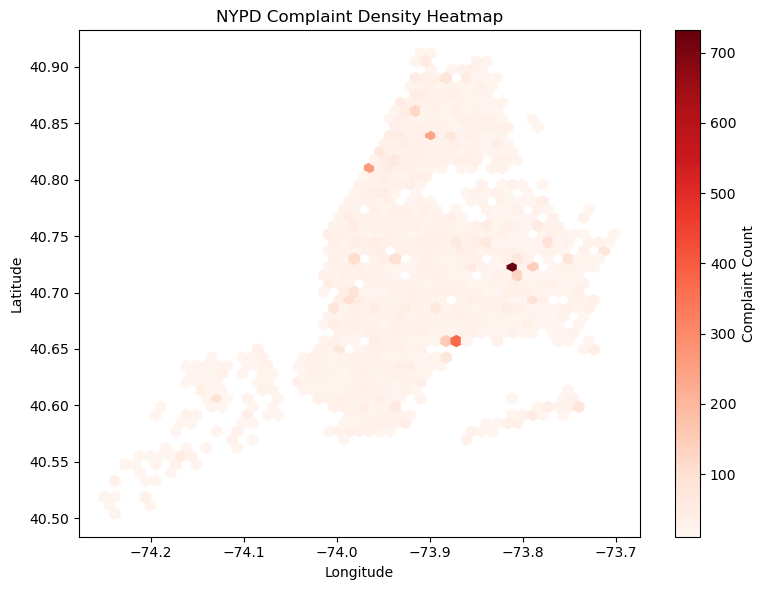

In [30]:
query = text(f"""
SELECT ROUND(latitude, 3) AS lat_bin, ROUND(longitude, 3) AS lon_bin, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND latitude IS NOT NULL AND longitude IS NOT NULL
GROUP BY lat_bin, lon_bin
HAVING count > 10
ORDER BY count DESC;
""")

with engine.connect() as conn:
    df_geo = pd.read_sql(query, conn)

# Visualization
plt.figure(figsize=(8, 6))
plt.hexbin(df_geo['lon_bin'], df_geo['lat_bin'], C=df_geo['count'], gridsize=50, cmap='Reds')
plt.colorbar(label='Complaint Count')
plt.title("NYPD Complaint Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


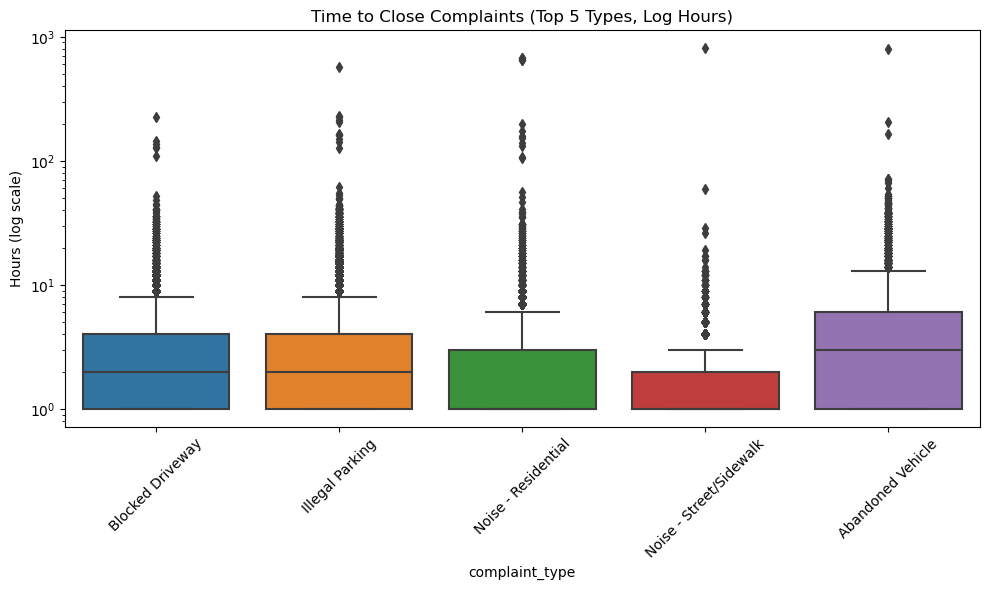

In [31]:
query = text(f"""
SELECT complaint_type,
       TIMESTAMPDIFF(HOUR, created_date, closed_date) AS hours_to_close
FROM {TABLE_NAME}
WHERE agency = 'NYPD'
  AND created_date IS NOT NULL AND closed_date IS NOT NULL
  AND TIMESTAMPDIFF(HOUR, created_date, closed_date) BETWEEN 1 AND 1000;
""")

with engine.connect() as conn:
    df_time_close = pd.read_sql(query, conn)

top_types = df_time_close['complaint_type'].value_counts().head(5).index
df_top_types = df_time_close[df_time_close['complaint_type'].isin(top_types)]

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top_types, x="complaint_type", y="hours_to_close")
plt.yscale("log")
plt.title("Time to Close Complaints (Top 5 Types, Log Hours)")
plt.ylabel("Hours (log scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


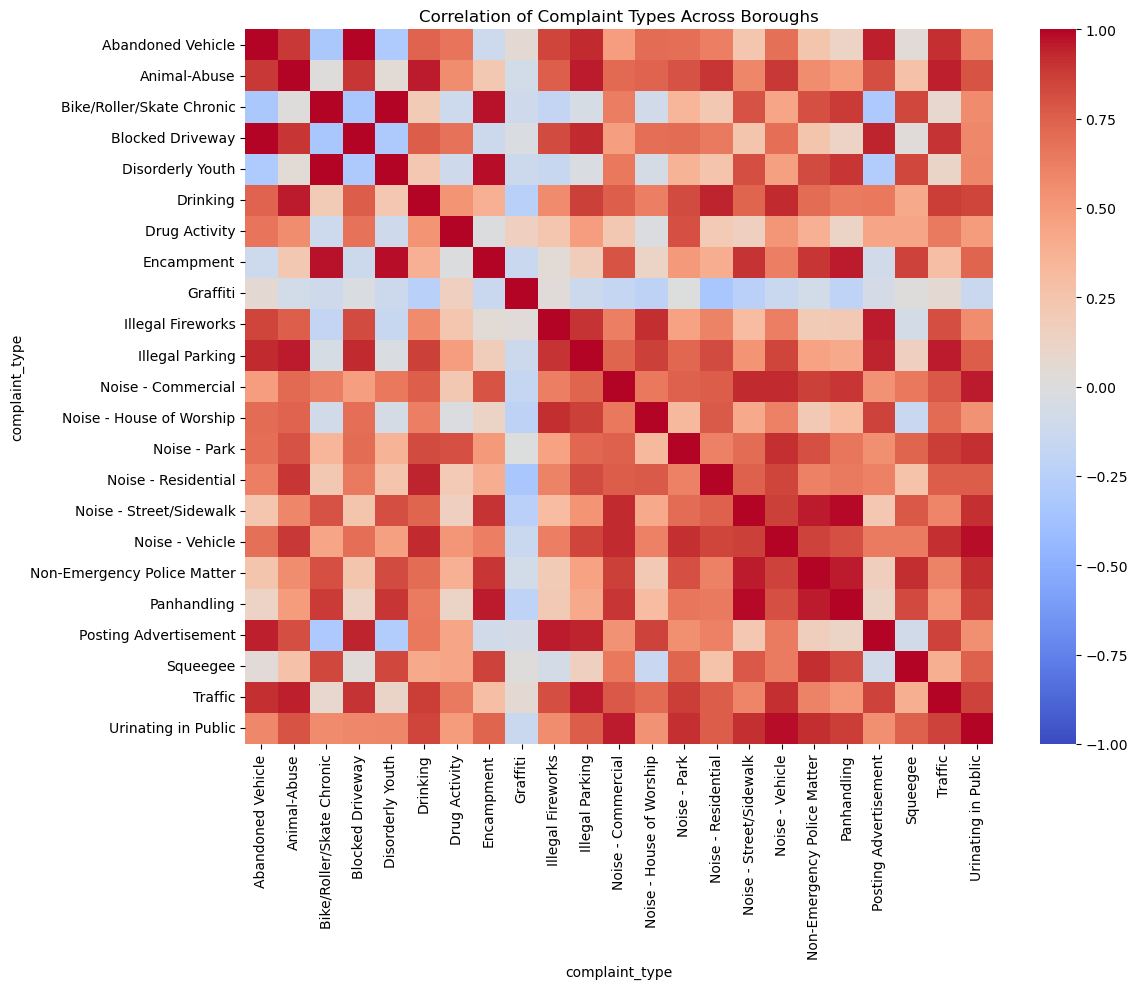

In [32]:
query = text(f"""
SELECT borough, complaint_type, COUNT(*) AS count
FROM {TABLE_NAME}
WHERE agency = 'NYPD' AND borough IS NOT NULL
GROUP BY borough, complaint_type;
""")

with engine.connect() as conn:
    df_corr = pd.read_sql(query, conn)

pivot = df_corr.pivot(index='borough', columns='complaint_type', values='count').fillna(0)
corr_matrix = pivot.corr()

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Correlation of Complaint Types Across Boroughs")
plt.tight_layout()
plt.show()
